In [79]:
# import os

# print(os.getcwd())
# print(os.path.dirname(os.path.abspath("__file__")))

In [80]:
# import sys
# import os
# from pathlib import Path
# print(sys.path.append(str(Path.cwd().parent.parent)))

In [81]:
# from pathlib import Path


# def dataDirectory(dataDirectoryName='data'):
#     """
#     Return the directory that contains the data.

#     We assume that the data folder is locate in a parent directory of this file and named 'data'.
#     If your setup is different, you will need to change this method.
#     """
#     # dataDir = sys.path.append(str(Path.cwd().parent.parent))
#     dataDir = Path(__file__).resolve().parent.parent
#     while not list(dataDir.rglob('data')):
#         dataDir = dataDir.parent
#     found = [d for d in dataDir.rglob('data') if d.is_dir()]
#     if not found:
#         raise Exception(f'Cannot find data directory with name {dataDirectoryName} along the path of your source files')
#     return found[0]

In [82]:
# !python common.py

from pathlib import Path
import common1

try:
    DATA = common1.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to datasets. If you don't keep your data in the same directory as to code, adapt the path names.

In [83]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

# Estimates of Location
## Example: Location Estimates of Population and Murder Rates

In [84]:
# import pandas for datasets manipulaion
import pandas as pd

state = pd.read_csv(STATE_CSV)
state.head(10)

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA
5,Colorado,5029196,2.8,CO
6,Connecticut,3574097,2.4,CT
7,Delaware,897934,5.8,DE
8,Florida,18801310,5.8,FL
9,Georgia,9687653,5.7,GA


Compute the mean, trimmed mean, and median for Population. For `mean` and `median` we can use the _pandas_ methods of the data frame. The trimmed mean requires the `trim_mean` function in _scipy.stats_.

In [85]:
# Calculating mean without library

from typing import List

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

mean(state['Population'])

6162876.3

In [86]:
state['Population'].mean()

np.float64(6162876.3)

In [87]:
# Calculating trimmed mean without library

def trimmed_mean(lst : List[float], alpha: float) -> float:
    # https://stackoverflow.com/questions/60317568/trimmed-mean-in-python
    s = sorted(lst)

    # Calculate number of elements to trim from the beginning and end
    a = round(alpha * len(lst))

    # Check if alpha can actually remove any elements and if not return straight mean
    if a == 0:
        return sum(lst) / len(lst)

    # Remove trimmed elements from the list
    trimmed_list = s[a: -a]

    # Check if there is a list left after trimming
    if len(trimmed_list) == 0:
        return

    # Calculate average on the new list
    trimmed_ave = sum(trimmed_list) / len(trimmed_list)
    return trimmed_ave

trimmed_mean(state['Population'], 0.1)


4783697.125

In [88]:
from scipy.stats import trim_mean
trim_mean(state['Population'], 0.1)

np.float64(4783697.125)

In [89]:
state['Population'].median()

np.float64(4436369.5)

In [90]:
# The underscores indicate that these are "private" functions, as they're
# intended to be called by our median function but not by other people
# using our statistics library

def _median_odd(xs: List[float]) -> float:
    """If len(xs) is odd, the median is the middle element"""
    return sorted(xs)[len(xs) // 2]

def _median_even(xs: List[float]) -> float:
    """If len(xs) is even, it's the average of the middle two elements"""
    sorted_xs = sorted(xs)
    hi_midpoint = len(xs) // 2
    return (sorted_xs[hi_midpoint - 1] + sorted_xs[hi_midpoint]) / 2

def median(v : List[float]) -> float:
    """Finds the 'middle-most value of v'"""
    return _median_even(v) if len(v) % 2 == 0 else _median_odd(v)

median(state['Population'])

4436369.5

In [91]:
import numpy as np
import wquantiles

print(np.average(state['Murder.Rate'], weights=state['Population']))
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

4.445833981123393
4.4


In [92]:
state['Murder.Rate'].head()
len(state)

50

In [93]:
# Calculating weight mean

def weight_mean(xs: List[float], ws: List[float]) -> float:
    return ((sum(x * w for x, w in zip(xs, ws))) / sum(ws))

def weight_median(xs: List[float], ws: List[float]) -> float:
    # https://medium.com/@elif_erkk/determining-new-facility-location-python-application-using-weighted-median-method-64e70074dab2
    sorted_pairs = sorted(zip(xs, ws))
    sorted_xs, sorted_ws = zip(*sorted_pairs)
    comulative_weight = 0
    for i in range(len(sorted_ws)):
        comulative_weight += sorted_ws[i]
        if comulative_weight >= sum(ws) / 2:
            return sorted_xs[i]

print(weight_mean(state['Murder.Rate'], state['Population']))
print(weight_median(state['Murder.Rate'], state['Population']))

4.445833981123394
4.4


In [94]:
from statsmodels import robust

print(state['Population'].std())
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))
print(robust.scale.mad(state['Population']))

6848235.347401142
4847308.0
3849876.1459979336


In [95]:
# Calculating Standard Deviation

import math

def dot(v: List[float], w: List[float]) -> float:
    """Compute v_1 * w_1 + ... + v_n + w_n"""
    assert len(v) == len(w), "vector must ve same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: List[float]) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def de_mean(xs: List[float]) -> List[float]:
    """Translate xs by substracting its mean (so the result has mean 0)"""
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n-1)

def standard_deviation(xs: List[float]) -> float:
    """The standart deviation is the square root of the variance"""
    return math.sqrt(variance(xs))

standard_deviation(state['Population'])

6848235.347401142

In [96]:
# Calculating Quantile
# Problem in interpolar

def quantile(xs: List[float], p: float) -> float:
    """Returns the pth-percentile value in x"""
    p_index = int(p * len(xs))
    # return sorted(xs)[p_index]
    return sorted(xs)[math.floor(p_index)]

def interquartile_range(xs: List[float]) -> float:
    """Return the difference between the 75%-ile and the 25%-ile"""
    return quantile(xs, 0.75) - quantile(xs, 0.25)

print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))
print(interquartile_range(state['Population']))

4847308.0
4898199


In [97]:
# Calculating Median Absolute Deviation

def de_median(xs: List[float]) -> List[float]:
    x_tilde = median(xs)
    return [x - x_tilde for x in xs]

def mad(xs: List[float]) -> float:
    return median(xs)

print(robust.scale.mad(state['Population']))
print(mad(state['Population']))

3849876.1459979336
4436369.5


In [98]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))
print(state['Population'].max())
print(state['Population'].median())

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64
37253956
4436369.5


In [99]:
print(quantile(state['Murder.Rate'], 0.05))
print(quantile(state['Murder.Rate'], 0.25))
print(quantile(state['Murder.Rate'], 0.5))
print(quantile(state['Murder.Rate'], 0.75))
print(quantile(state['Murder.Rate'], 0.95))

print(max(state['Population']))
print(median(state['Population']))

1.6
2.4
4.0
5.6
6.6
37253956
4436369.5


Text(0, 0.5, 'Population(millions)')

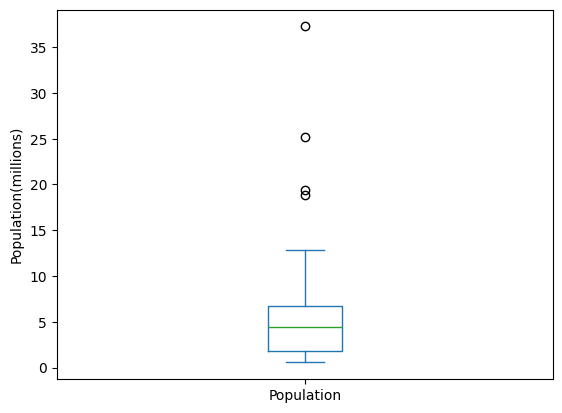

In [100]:
ax = (state['Population'] / 1_000_000).plot.box()
ax.set_ylabel('Population(millions)')

In [101]:
state['Population'].value_counts()

Population
4779736     1
710231      1
6392017     1
2915918     1
37253956    1
5029196     1
3574097     1
897934      1
18801310    1
9687653     1
1360301     1
1567582     1
12830632    1
6483802     1
3046355     1
2853118     1
4339367     1
4533372     1
1328361     1
5773552     1
6547629     1
9883640     1
5303925     1
2967297     1
5988927     1
989415      1
1826341     1
2700551     1
1316470     1
8791894     1
2059179     1
19378102    1
9535483     1
672591      1
11536504    1
3751351     1
3831074     1
12702379    1
1052567     1
4625364     1
814180      1
6346105     1
25145561    1
2763885     1
625741      1
8001024     1
6724540     1
1852994     1
5686986     1
563626      1
Name: count, dtype: int64

In [102]:
binnedPopulation = pd.cut(state['Population'], 10)
binnedPopulation.value_counts()

Population
(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: count, dtype: int64

In [103]:
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })

print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3920\2388207464.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df.groupby(by='binnedPopulation'):


Text(0.5, 0, 'Population (millions)')

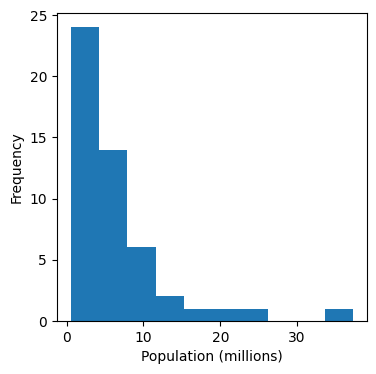

In [104]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel("Population (millions)")

Text(0.5, 0, 'Murder Rate (per 100,000)')

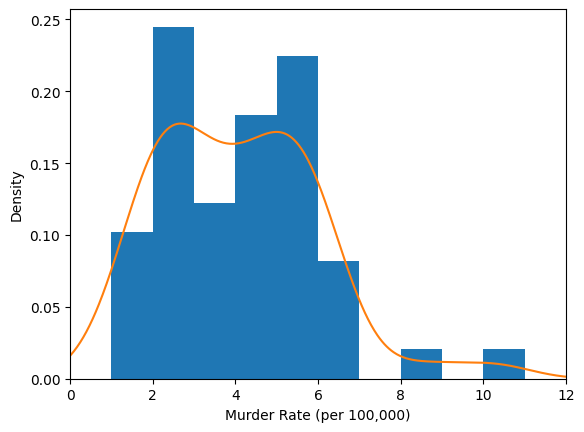

In [105]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], bins=range(1, 12))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

In [106]:
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
print(100 * dfw / dfw.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


Text(0, 0.5, 'Count')

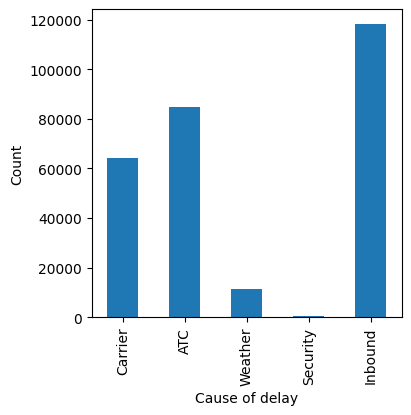

In [107]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

In [108]:
sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [109]:
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]


In [110]:
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2012-07-05  0.150440  0.096313 -0.103487  0.149420  0.239991   6.56 -0.070000   
2012-07-06 -0.141040 -0.491201  0.018819 -0.205449 -0.519989  -8.80 -0.180000   
2012-07-09  0.244465 -0.048160 -0.056445 -0.168094  0.429992  -0.48  0.459999   

                 IWM       XLE       XLY       XLU       XLB       XTL  \
2012-07-02  0.534641  0.028186  0.095759  0.098311 -0.093713  0.019076   
2012-07-03  0.926067  0.995942  0.000000 -0.044686  0.337373  0.000000   
2012-07-05 -0.171848 -0.460387  0.306431 -0.151938  0.103086  0.019072   
2012-07-06 -0.229128  0.206706  0.153214  0.080437  0.018744 -0.429213   
2012-07-09 -0.190939 -0.234892 -0.201098 -0.035751 -0.168687  0.000000   

                 XLV       XLP       XLF       XLK  
2012-07-02 -0.0

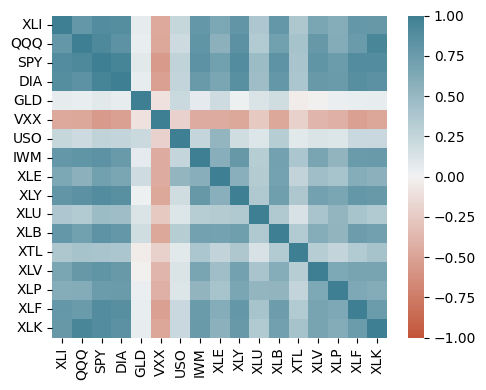

In [111]:
import matplotlib.pylab as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), ax=ax)
plt.tight_layout()
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3920\2715700108.py:38: UserWarning: Adding colorbar to a different Figure <Figure size 500x400 with 2 Axes> than <Figure size 500x400 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(m, ax=ax)


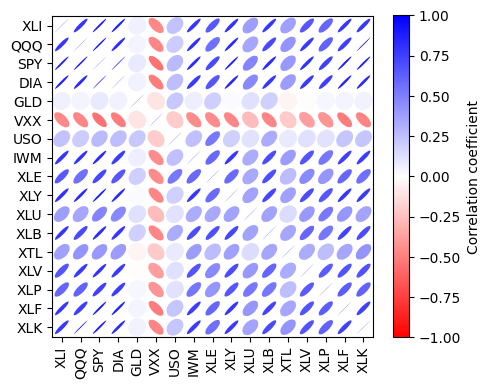

In [112]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

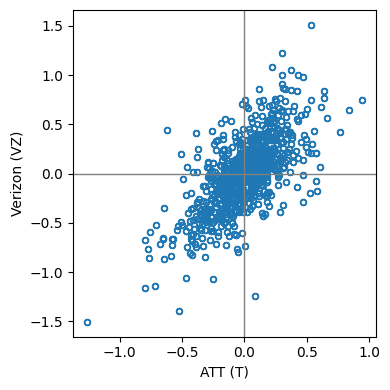

In [113]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

In [114]:
etfs.head(10)

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
2012-07-02,-0.376098,0.096313,0.028223,-0.242796,0.419998,-10.40,0.000000,0.534641,0.028186,0.095759,0.098311,-0.093713,0.019076,-0.009529,0.313499,0.018999,0.075668
2012-07-03,0.376099,0.481576,0.874936,0.728405,0.490006,-3.52,0.250000,0.926067,0.995942,0.000000,-0.044686,0.337373,0.000000,0.000000,0.129087,0.104492,0.236462
2012-07-05,0.150440,0.096313,-0.103487,0.149420,0.239991,6.56,-0.070000,-0.171848,-0.460387,0.306431,-0.151938,0.103086,0.019072,-0.142955,-0.073766,-0.142490,0.066211
2012-07-06,-0.141040,-0.491201,0.018819,-0.205449,-0.519989,-8.80,-0.180000,-0.229128,0.206706,0.153214,0.080437,0.018744,-0.429213,-0.095304,0.119865,0.066495,-0.227003
2012-07-09,0.244465,-0.048160,-0.056445,-0.168094,0.429992,-0.48,0.459999,-0.190939,-0.234892,-0.201098,-0.035751,-0.168687,0.000000,0.352630,-0.064548,0.018999,0.009457
2012-07-10,-0.733400,-0.943887,-1.759260,-1.503506,-2.980011,9.92,-0.630002,-1.412963,-1.343584,-0.459646,0.017875,-0.656002,0.000000,-0.381215,-0.082985,-0.208985,-0.406716
2012-07-11,-0.244464,-0.260052,-0.047042,-0.485600,0.410003,-6.88,0.380001,-0.315054,0.507361,-0.229821,0.107248,-0.215543,0.000000,0.000000,-0.110646,0.104492,-0.104044
2012-07-12,0.065818,-0.086684,0.122292,0.336188,1.330001,-3.84,0.360001,0.334147,0.526164,0.134062,0.071497,0.215542,0.000000,0.123893,0.082986,-0.018999,-0.075668
2012-07-13,0.554749,0.751261,1.778079,1.587556,0.690002,-9.92,0.290001,0.668292,0.826819,0.612860,0.223435,0.477946,0.000000,0.390749,0.267398,0.313477,0.293214
2012-07-16,-0.075218,-0.038527,-0.009416,-0.121398,-0.219986,-2.24,0.320000,-0.162306,0.404015,-0.038305,0.017876,-0.056226,0.000000,0.104836,-0.082985,-0.037997,-0.028375


In [115]:
# Correlation between two variable

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys), "xs and ys must have same number of elements"
    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

def correlation(xs: List[float], ys: List[float]) -> float:
    """Meansures how much xs and ys vary in tandem their meeans"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero

correlation(telecom['T'], telecom['VZ'])

0.6776124610128043

In [116]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000)
                     & (kc_tax.SqFtTotLiving > 100)
                     & (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

(432693, 3)


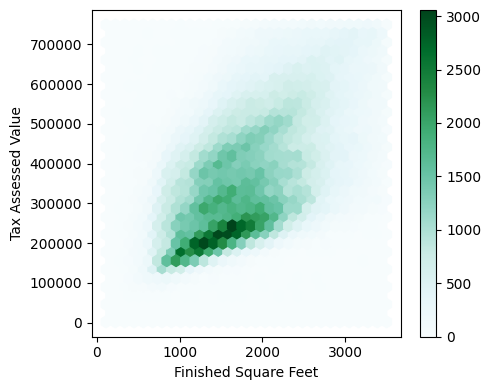

In [117]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

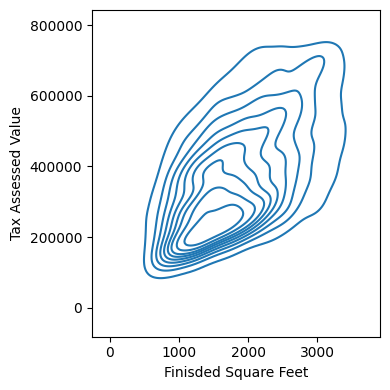

In [118]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)
ax.set_xlabel('Finisded Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

In [119]:
lc_loans = pd.read_csv(LC_LOANS_CSV)

crosstab = lc_loans.pivot_table(index='grade', columns='status', aggfunc=lambda x: len(x), margins=True)
print(crosstab)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [120]:
df = crosstab.copy().loc['A': 'G', :]
df.loc[:, 'Charged Off': 'Late'] = df.loc[:, 'Charged Off': 'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3920\1055530761.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0215478  0.04005439 0.04982834 0.06740983 0.08165728 0.1182579
 0.12619562]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Charged Off': 'Late'] = df.loc[:, 'Charged Off': 'Late'].div(df['All'], axis=0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_3920\1055530761.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.69045386 0.70901262 0.73570217 0.71732838 0.70793587 0.65437074
 0.61400802]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Charged Off': 'Late'] = df.loc[:, 'Charged Off': 'Late'].div(df['All'], axis=0)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_3920\1055530761.py:2: FutureWarning: Setting an item of incompat

In [121]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head(10)

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American
5,6.163889,3.225000,0.975000,American
6,7.744161,10.642251,1.460722,American
7,9.070175,8.078947,0.728070,American
8,10.406593,8.164835,0.838828,American
9,9.769784,5.971223,0.712230,American


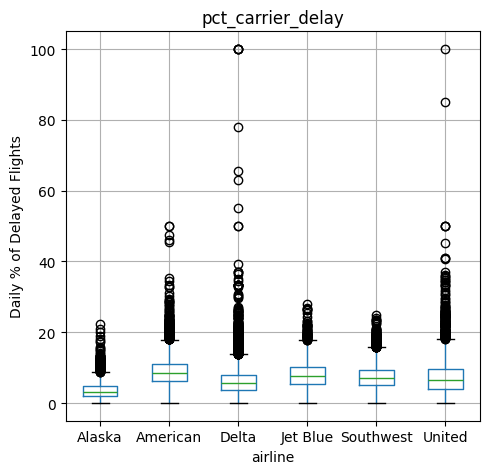

In [122]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay', figsize=(5, 5))
ax.set_label('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

plt.tight_layout()
plt.show()

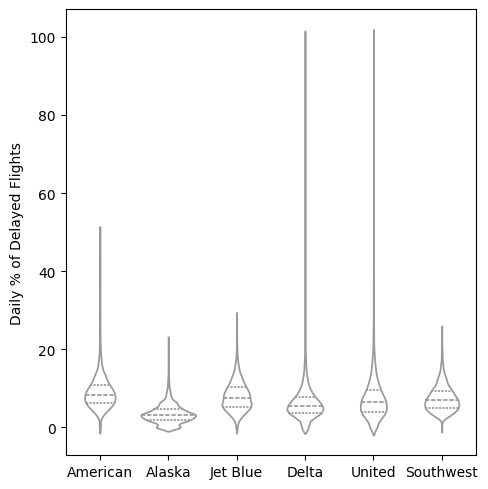

In [123]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x='airline', y='pct_carrier_delay', ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

In [124]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes), :]
kc_tax_zip

,TaxAssessedValue,SqFtTotLiving,ZipCode
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
10,202000.0,830,98108.0
11,210000.0,1130,98108.0
12,193000.0,1560,98108.0
...,...,...,...
498049,346000.0,1430,98105.0
498050,463000.0,1610,98105.0
498051,553000.0,1580,98105.0
498052,571000.0,1840,98105.0


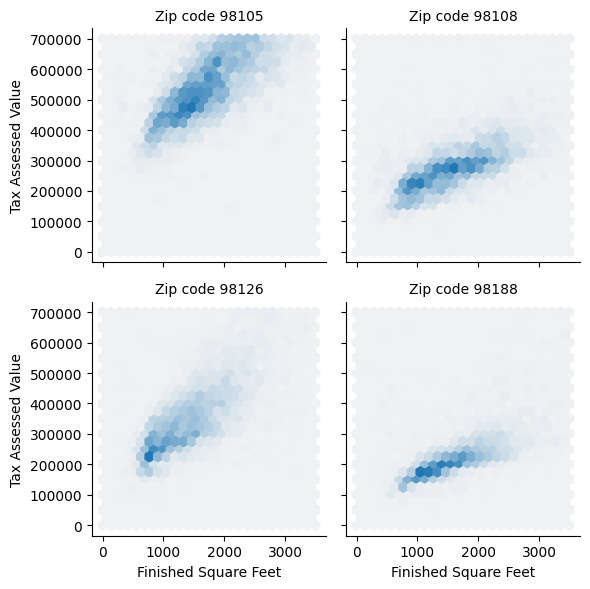

In [126]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()